### **Importowanie niezbędnych zależności oraz podłączanie Dysku Google (na którym zostanie zapisany wytrenowany model)**

W celu utworzenia kopii notatnika, na której można swobodnie pracować, należy wybrać Plik -> Zapisz kopię na Dysku

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Pobieranie zbioru danych**

Zbiór pochodzi ze strony: [Kaggle.com](https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed) oraz bazuje na innym zbiorze: [Kaggle.com](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)

Wykorzystano z niego pliku "Shuffling, /255.0 + Mean Normalization"

* Plik z rozszerzeniem .pickle - Plik utworzony przez moduł pickle, który 
umożliwia serializowanie obiektów w Pythonie do plików na dysku i przekształcanie ich z powrotem w program w środowisku wykonawczym; zapisuje strumień bajtów, który reprezentuje obiekty 

In [3]:
%mkdir dataset
%cd dataset
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1NTII7sUWscYacSOr7A7ARLDeZBnJkf8w' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1NTII7sUWscYacSOr7A7ARLDeZBnJkf8w" -O CNN_dataset.zip && rm -rf /tmp/cookies.txt
!unzip CNN_dataset.zip && rm -f CNN_dataset.zip
%cd ..

/content/dataset
--2021-07-10 15:45:40--  https://docs.google.com/uc?export=download&confirm=AFGy&id=1NTII7sUWscYacSOr7A7ARLDeZBnJkf8w
Resolving docs.google.com (docs.google.com)... 108.177.96.138, 108.177.96.102, 108.177.96.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.96.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-4g-docs.googleusercontent.com/docs/securesc/3rhckvjmc2mg6uabatnv9ommuqa7ievm/iijuojvhk2tjt9428rhfg09jq1f2j9sk/1625931900000/00420921083952279027/06277449679205104828Z/1NTII7sUWscYacSOr7A7ARLDeZBnJkf8w?e=download [following]
--2021-07-10 15:45:40--  https://doc-0g-4g-docs.googleusercontent.com/docs/securesc/3rhckvjmc2mg6uabatnv9ommuqa7ievm/iijuojvhk2tjt9428rhfg09jq1f2j9sk/1625931900000/00420921083952279027/06277449679205104828Z/1NTII7sUWscYacSOr7A7ARLDeZBnJkf8w?e=download
Resolving doc-0g-4g-docs.googleusercontent.com (doc-0g-4g-docs.googleusercontent.com)... 173.194.69.132, 2a00:1450:4013:c

In [6]:
with open('dataset/dataset.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

### **Normalizacja zdjęć poprzez sprowadzenie wartości pikseli z przedziału (0,255) do przedziału (0,1)**

In [7]:
x_train_255 = data['x_train'] / 255.0

mean_image_rgb = np.mean(x_train_255, axis=0)
with open('mean_image_rgb.pickle', 'wb') as handler:
    pickle.dump(mean_image_rgb, handler)

### **Przykładowe elementy zbioru**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


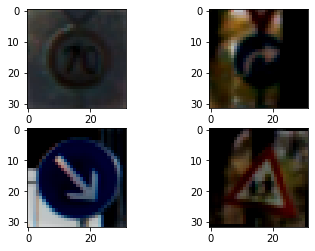

In [11]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(data['x_train'][25], cmap='gray')
axarr[0,1].imshow(data['x_train'][14], cmap='gray')
axarr[1,0].imshow(data['x_train'][2], cmap='gray')
axarr[1,1].imshow(data['x_train'][15], cmap='gray')

### **Definiowanie struktury konwolucyjnej sieci neuronowej i trenowanie**

In [38]:
kernel_size = 3

model = Sequential()
model.add(Conv2D(32, kernel_size=kernel_size, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Conv2D(64, kernel_size=kernel_size, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               2048500   
_________________________________________________________________
dense_1 (Dense)              (None, 43)                2

In [45]:
epochs = 12
history = model.fit(data['x_train'], data['y_train'],
                    batch_size=15, epochs = epochs,
                    validation_data = (data['x_validation'], data['y_validation']), verbose=1)

Epoch 1/12
5800/5800 [==============================] - 19s 3ms/step - loss: 0.0253 - accuracy: 0.9952 - val_loss: 1.0013 - val_accuracy: 0.9374
Epoch 2/12
5800/5800 [==============================] - 20s 3ms/step - loss: 0.0216 - accuracy: 0.9958 - val_loss: 1.6791 - val_accuracy: 0.9215
Epoch 3/12
5800/5800 [==============================] - 19s 3ms/step - loss: 0.0235 - accuracy: 0.9959 - val_loss: 1.4598 - val_accuracy: 0.9254
Epoch 4/12
5800/5800 [==============================] - 19s 3ms/step - loss: 0.0229 - accuracy: 0.9962 - val_loss: 1.4480 - val_accuracy: 0.9159
Epoch 5/12
5800/5800 [==============================] - 19s 3ms/step - loss: 0.0232 - accuracy: 0.9962 - val_loss: 1.3520 - val_accuracy: 0.9247
Epoch 6/12
5800/5800 [==============================] - 19s 3ms/step - loss: 0.0220 - accuracy: 0.9961 - val_loss: 2.0057 - val_accuracy: 0.9163
Epoch 7/12
5800/5800 [==============================] - 19s 3ms/step - loss: 0.0238 - accuracy: 0.9964 - val_loss: 1.4721 - val_ac

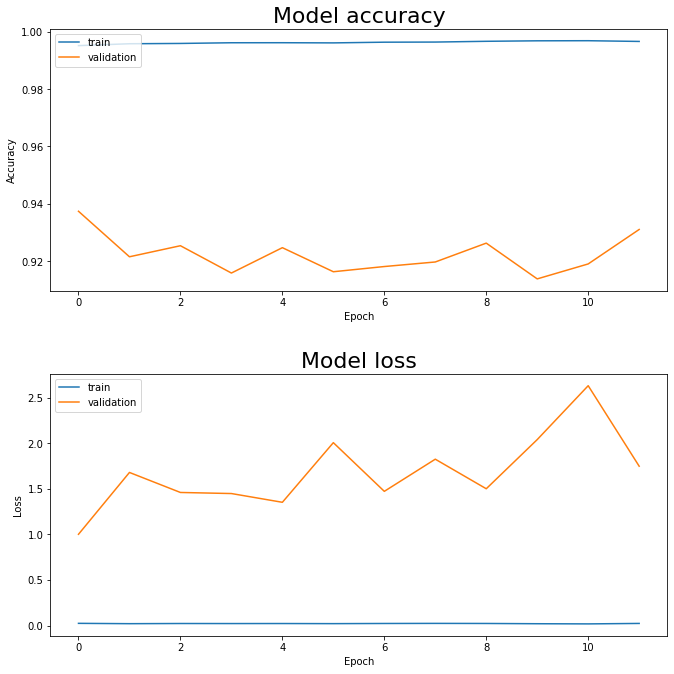

In [46]:
plt.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.title('Model accuracy', fontsize=22)

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model loss', fontsize=22)
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout(3)
plt.show()

### **Określanie dokładności na zbiorze testowym**

In [47]:
test_accuracy = model.predict(data['x_test'])
test_accuracy = np.argmax(test_accuracy, axis=1)
test_accuracy = np.mean(test_accuracy == data['y_test'])
print('Dokładność detekcji na zbiorze testowym = {:.5f}'.format(test_accuracy))

Dokładność detekcji na zbiorze testowym = 0.92415


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


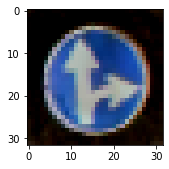

Class ID predicted by model: [ 36 ] Nakaz jazdy prosto lub w prawo
Labeled Class ID and Name:  [14] Nakaz jazdy prosto lub w prawo


In [63]:
def label_text(file):
    label_list = []
    labels = pd.read_csv(file)
    for name in labels['SignName']: label_list.append(name)
    return label_list

labels = label_text('dataset/labels.csv')
plt.rcParams['figure.figsize'] = (2.5, 2.5)
x_input = data['x_test'][162:163]
plt.imshow(x_input[0, :, :, :])
plt.show()

scores = model.predict(x_input)
prediction = np.argmax(scores)
print('Class ID predicted by model: [', prediction, ']', labels[prediction])
x_input = data['x_test'][95:96]
y_input = data['y_test'][95:96]
print('Labeled Class ID and Name: ', y_input,labels[prediction])


### **Zapisywanie mean_image_rgb.pickle oraz  wytrenowanego modelu Keras na Dysku Google**

In [64]:
model.save('trained_keras_model')
%cp -r trained_keras_model/ drive/'My Drive'/
%cp mean_image_rgb.pickle drive/'My Drive'/

INFO:tensorflow:Assets written to: trained_keras_model/assets
